*Curso: Big Data - Métodos Intensivos de Computación*</br>
*Presentado por: Boris Mauricio Martinez Gutierrez*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/BigData

Mounted at /content/drive
/content/drive/MyDrive/BigData


In [ ]:
# instala la version mas reciente de dask
!pip install distributed==2021.4.0

Reddit Comments
-----------------

[Download link](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/)

Every publicly available reddit comment, available as a large torrent

**Try the following:**

*  Use `dask.bag` to inspect the data
*  Combine `dask.bag` with `nltk` or `gensim` to perform textual analyis on the data
*  Reproduce the work of [Daniel Rodriguez](https://extrapolations.dev/blog/2015/07/reproduceit-reddit-word-count-dask/) and see if you can improve upon his speeds when analyzing this data.

In [ ]:
# directorio del dataset
import os

path = os.path.join('dask','data','reddit')
if not os.path.exists(path):
  os.makedirs(path)

path

'dask/data/reddit'

In [ ]:
!ls 'dask/data/reddit'

RC_2015-01.bz2


In [ ]:
# tamaño en disco del dataset
!du -sh dask/data/reddit

5.1G	dask/data/reddit


In [ ]:
from dask.distributed import Client
client = Client()

In [ ]:
import dask.bag as db
import json

data = db.read_text(os.path.join(path, 'RC_2015-01.bz2')).map(json.loads)
data.take(1)

({'archived': False,
  'author': 'YoungModern',
  'author_flair_css_class': None,
  'author_flair_text': None,
  'body': 'Most of us have some family members like this. *Most* of my family is like this. ',
  'controversiality': 0,
  'created_utc': '1420070400',
  'distinguished': None,
  'downs': 0,
  'edited': False,
  'gilded': 0,
  'id': 'cnas8zv',
  'link_id': 't3_2qyr1a',
  'name': 't1_cnas8zv',
  'parent_id': 't3_2qyr1a',
  'retrieved_on': 1425124282,
  'score': 14,
  'score_hidden': False,
  'subreddit': 'exmormon',
  'subreddit_id': 't5_2r0gj',
  'ups': 14},)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

# funciones para filtrar los datos
only_movies = lambda x: x['subreddit'] == 'movies'
no_stopwords = lambda word: word not in stopwords.words('english')
is_word = lambda word: re.search('^[0-9a-zA-Z]+$', word) is not None

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# el análisis de palabras corresponde al tema: peliculas
topic = data.filter(only_movies)
topic.take(1)

({'archived': False,
  'author': 'kylionsfan',
  'author_flair_css_class': None,
  'author_flair_text': None,
  'body': 'Goonies',
  'controversiality': 0,
  'created_utc': '1420070402',
  'distinguished': None,
  'downs': 0,
  'edited': False,
  'gilded': 0,
  'id': 'cnas90u',
  'link_id': 't3_2qyjda',
  'name': 't1_cnas90u',
  'parent_id': 't3_2qyjda',
  'retrieved_on': 1425124282,
  'score': 1,
  'score_hidden': False,
  'subreddit': 'movies',
  'subreddit_id': 't5_2qh3s',
  'ups': 1},)

In [ ]:
# todos comentarios sobre el tema: películas
comments = topic.pluck('body')
comments.take(4)

('Goonies',
 'Grosse Pointe Blank',
 'I agree. The first 90 mins was like an expose in how to spend too much time in a scene. And then the last 30 was real quick. The end. It was like a student picture. ',
 'Who was vote?\n\nCoke, Panasonic, Ford, Paramount, ')

In [ ]:
# comentarios tokenizados (comentarios como lista de palabras)
words = comments.map(nltk.word_tokenize).flatten()
words.take(4)

('Goonies', 'Grosse', 'Pointe', 'Blank')

In [ ]:
# palabras en minuscula
lcase_words = words.map(lambda x: x.lower())
lcase_words.take(4)

('goonies', 'grosse', 'pointe', 'blank')

In [ ]:
# solo palabras relevantes (diferentes de articulos, pronombres, etc)
words2 = lcase_words.filter(no_stopwords).filter(is_word)
words2.take(4)

('goonies', 'grosse', 'pointe', 'blank')

In [ ]:
# frecuencia de cada palabra
counts = words2.frequencies()
%time word_count = counts.compute()

CPU times: user 5min 56s, sys: 39.5 s, total: 6min 35s
Wall time: 1h 43min 15s


In [ ]:
len(word_count)

83626

In [ ]:
word_count_sorted = sorted(word_count, key=lambda x: x[1], reverse=True)
word_count_sorted[:10]

[('movie', 76003),
 ('like', 55803),
 ('one', 39800),
 ('would', 37207),
 ('think', 33944),
 ('film', 33199),
 ('people', 32332),
 ('really', 31971),
 ('movies', 29981),
 ('good', 28033)]

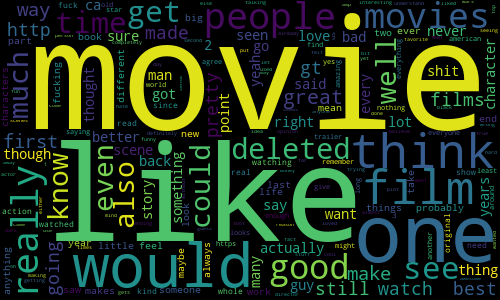

In [ ]:
# nube de palabras
from wordcloud import WordCloud

frequencies_dict = {t[0]:t[1] for t in word_count_sorted}
WordCloud(width=500, height=300).generate_from_frequencies(frequencies_dict).to_image()

In [ ]:
client.close()